
# Predicción puntual e intervalos de confianza


In [10]:

# --- Importación de librerías ---
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from IPython.display import display

# Ajustes generales
pd.set_option('display.float_format', '{:,.3f}'.format)


## Cargar datos

In [11]:

# Conjunto clásico de datos económicos de EE.UU. (1947–1962)
data = sm.datasets.longley.load_pandas().data

print("Dimensiones:", data.shape)
display(data.head())

# Variable dependiente y explicativas
y = data['TOTEMP']          # Empleo total (objetivo)
X = data.drop(columns=['TOTEMP'])  # Explicativas
X = sm.add_constant(X)      # Añadimos término independiente


Dimensiones: (16, 7)


,TOTEMP,GNPDEFL,GNP,UNEMP,ARMED,POP,YEAR
0,"60,323.000",83.000,"234,289.000","2,356.000","1,590.000","107,608.000","1,947.000"
1,"61,122.000",88.500,"259,426.000","2,325.000","1,456.000","108,632.000","1,948.000"
2,"60,171.000",88.200,"258,054.000","3,682.000","1,616.000","109,773.000","1,949.000"
3,"61,187.000",89.500,"284,599.000","3,351.000","1,650.000","110,929.000","1,950.000"
4,"63,221.000",96.200,"328,975.000","2,099.000","3,099.000","112,075.000","1,951.000"


## Ajuste del modelo OLS

In [12]:

modelo = sm.OLS(y, X).fit()
print(modelo.summary())


                            OLS Regression Results                            
Dep. Variable:                 TOTEMP   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     330.3
Date:                Sun, 09 Nov 2025   Prob (F-statistic):           4.98e-10
Time:                        21:29:59   Log-Likelihood:                -109.62
No. Observations:                  16   AIC:                             233.2
Df Residuals:                       9   BIC:                             238.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.482e+06    8.9e+05     -3.911      0.0

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=16 observations were given.
  return hypotest_fun_in(*args, **kwds)


## Predicción e intervalos

In [ ]:

# Seleccionamos, por ejemplo, las 3 primeras filas para ilustrar
X_pred = X.iloc[:3]
predicciones = modelo.get_prediction(X_pred)
pred_summary = predicciones.summary_frame(alpha=0.05)  # 95%

print("Predicciones y bandas (95%):")
display(pred_summary)

# Columnas:
# - mean: predicción puntual del valor esperado E[Y|X]
# - mean_ci_lower, mean_ci_upper: IC para el valor esperado
# - obs_ci_lower, obs_ci_upper: intervalo de predicción puntual


Predicciones y bandas (95%):


,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,"60,055.660",198.632,"59,606.323","60,504.997","59,232.562","60,878.758"
1,"61,216.014",229.144,"60,697.655","61,734.373","60,353.296","62,078.732"
2,"60,124.713",183.439,"59,709.746","60,539.680","59,319.862","60,929.563"


## Visualización de la incertidumbre

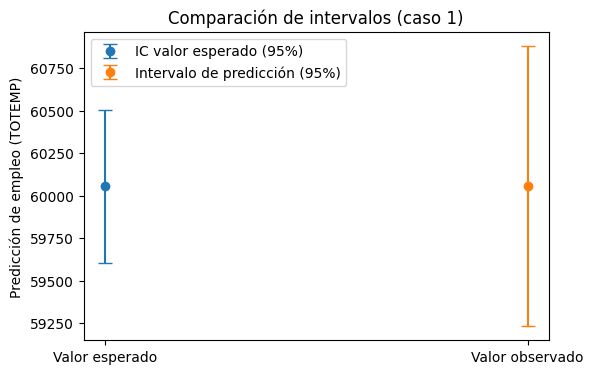

In [14]:

# Elegimos el primer caso para graficar
i = pred_summary.index[0]
mean_pred = pred_summary.loc[i, 'mean']
mean_ci_low = pred_summary.loc[i, 'mean_ci_lower']
mean_ci_up  = pred_summary.loc[i, 'mean_ci_upper']
obs_ci_low  = pred_summary.loc[i, 'obs_ci_lower']
obs_ci_up   = pred_summary.loc[i, 'obs_ci_upper']

plt.figure(figsize=(6,4))

# IC del valor esperado
plt.errorbar(x=['Valor esperado'], y=[mean_pred],
             yerr=[[mean_pred - mean_ci_low], [mean_ci_up - mean_pred]],
             fmt='o', capsize=5, label='IC valor esperado (95%)')

# Intervalo de predicción (valor individual futuro)
plt.errorbar(x=['Valor observado'], y=[mean_pred],
             yerr=[[mean_pred - obs_ci_low], [obs_ci_up - mean_pred]],
             fmt='o', capsize=5, label='Intervalo de predicción (95%)')

plt.title("Comparación de intervalos (caso 1)")
plt.ylabel("Predicción de empleo (TOTEMP)")
plt.legend()
plt.show()


## Predicción para nuevos datos

In [15]:

# Construimos un punto fuera de la muestra (ajusta los valores a conveniencia)
nuevo_X = pd.DataFrame({
    'const': [1.0],
    'GNPDEFL': [90.0],
    'GNP': [470.0],
    'UNEMP': [5.0],
    'ARMED': [230.0],
    'POP': [120.0],
    'YEAR': [1963.0]
})

pred_nuevo = modelo.get_prediction(nuevo_X).summary_frame(alpha=0.05)
print("Predicción para un nuevo punto (95%):")
display(pred_nuevo)


Predicción para un nuevo punto (95%):


,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,"109,450.548","17,944.902","68,856.359","150,044.738","68,850.501","150,050.595"



## Visualización comparativa global de bandas (valor esperado vs. predicción)

En esta sección representamos, para **todas** las observaciones, la predicción puntual, el **IC del valor esperado** y el **intervalo de predicción**.  
Ordenamos por YEAR para facilitar la lectura temporal.


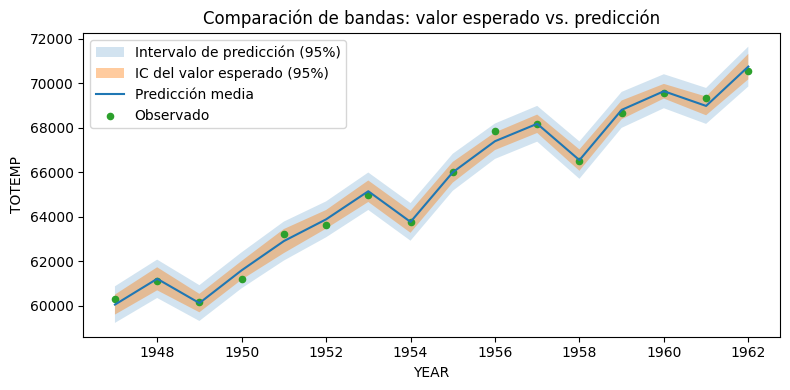

In [16]:

# Predicciones para todas las observaciones
pred_all = modelo.get_prediction(X).summary_frame(alpha=0.05).copy()

# Construimos un DataFrame auxiliar con YEAR como eje horizontal
viz = pred_all.copy()
viz['YEAR'] = X['YEAR'].values
viz['y_obs'] = y.values
viz = viz.sort_values('YEAR').reset_index(drop=True)

# Gráfico 1: bandas a lo largo del tiempo (YEAR)
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))

# Banda de intervalo de predicción (más ancha)
plt.fill_between(viz['YEAR'], viz['obs_ci_lower'], viz['obs_ci_upper'], alpha=0.2, label='Intervalo de predicción (95%)')

# Banda de IC del valor esperado (más estrecha)
plt.fill_between(viz['YEAR'], viz['mean_ci_lower'], viz['mean_ci_upper'], alpha=0.4, label='IC del valor esperado (95%)')

# Línea de la predicción media
plt.plot(viz['YEAR'], viz['mean'], label='Predicción media')

# Observaciones reales
plt.scatter(viz['YEAR'], viz['y_obs'], s=20, label='Observado')

plt.xlabel('YEAR')
plt.ylabel('TOTEMP')
plt.title('Comparación de bandas: valor esperado vs. predicción')
plt.legend()
plt.tight_layout()
plt.show()
